### Video maker

In [5]:
import cv2
import os
import numpy as np

def create_video_from_images(folder_path, fps=2, video_name='output_video.mp4'):
    """
    从指定文件夹中的图像创建视频。

    参数:
        folder_path (str): 包含图像的文件夹路径。
        fps (int): 视频的帧率，默认为2 fps。
        video_name (str): 输出视频文件的名称，默认为'output_video.mp4'。
    """
    # 获取文件夹中的所有图像文件
    images = [img for img in os.listdir(folder_path) if img.endswith(".png") or img.endswith(".jpg") or img.endswith(".jpeg")]
    images.sort()  # 确保图像是按顺序处理的

    # 读取第一张图像以获取视频的尺寸
    frame = cv2.imread(os.path.join(folder_path, images[0]))
    height, width, layers = frame.shape

    # 定义视频编码器和创建VideoWriter对象
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 'mp4v' for .mp4 files
    video_path = os.path.join(folder_path, video_name)
    video = cv2.VideoWriter(video_path, fourcc, fps, (width, height))

    # 将图像添加到视频
    for image in images:
        img_path = os.path.join(folder_path, image)
        frame = cv2.imread(img_path)
        if frame is None:
            continue  # 如果图像文件无法读取，则跳过
        video.write(frame)

    # 释放VideoWriter
    video.release()
    print(f"Video saved at {video_path}")

# 使用示例
folder_path = '/home/sherlock/Documents/Projects/HDMapNet-test/segment_result/MB_dataset2/n005_E43proE7_wb_full'  # 替换为你的图像文件夹路径
create_video_from_images(folder_path)


Video saved at /home/sherlock/Documents/Projects/HDMapNet-test/segment_result/MB_dataset2/n005_E43proE7_wb_full/output_video.mp4


### Image rotation

In [4]:
import cv2
import os
import numpy as np

def rotate_and_crop_image(image, angle):
    """
    旋转图像并根据旋转后的角点坐标裁剪图像。

    参数:
        image (numpy.ndarray): 输入图像。
        angle (float): 旋转角度（逆时针方向）。

    返回:
        numpy.ndarray: 裁剪并缩放后的图像。
    """
    height, width = image.shape[:2]
    center = (width // 2, height // 2)

    # 计算旋转矩阵
    rotation_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    abs_cos = abs(rotation_mat[0, 0])
    abs_sin = abs(rotation_mat[0, 1])

    # 计算新图像的边界
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # 调整旋转矩阵以考虑平移
    rotation_mat[0, 2] += bound_w / 2 - center[0]
    rotation_mat[1, 2] += bound_h / 2 - center[1]

    # 执行旋转
    rotated = cv2.warpAffine(image, rotation_mat, (bound_w, bound_h))

    # 计算旋转后四个角的坐标
    corners = np.array([
        [0, 0],
        [width, 0],
        [width, height],
        [0, height]
    ])
    ones = np.ones((corners.shape[0], 1))
    corners_homog = np.hstack([corners, ones])
    rotated_corners = corners_homog.dot(rotation_mat.T).astype(int)

    # 根据旋转角度的正负决定裁剪区域
    if angle > 0:
        x_min = max(rotated_corners[3][0], rotated_corners[0][0])
        x_max = min(rotated_corners[2][0], rotated_corners[1][0])
        y_min = rotated_corners[0][1]
        y_max = rotated_corners[2][1]
    else:
        x_min = max(rotated_corners[0][0], rotated_corners[3][0])
        x_max = min(rotated_corners[1][0], rotated_corners[2][0])
        y_min = rotated_corners[1][1]
        y_max = rotated_corners[3][1]

    # 裁剪图像
    cropped = rotated[y_min:y_max, x_min:x_max]

    # 缩放回原始尺寸
    resized = cv2.resize(cropped, (width, height), interpolation=cv2.INTER_LINEAR)

    return resized

def process_images(folder_path, angle):
    """
    处理指定文件夹中的所有图像，旋转和裁剪后保存到新文件夹。

    参数:
        folder_path (str): 图像文件夹的路径。
        angle (float): 旋转角度。
    """
    processed_folder = os.path.join(folder_path, "processed_imgs")
    if not os.path.exists(processed_folder):
        os.makedirs(processed_folder)

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            image = cv2.imread(img_path)
            if image is None:
                continue  # 如果图像文件无法读取，则跳过

            # 旋转和裁剪图像
            processed_img = rotate_and_crop_image(image, angle)
            # 保存处理后的图像
            processed_path = os.path.join(processed_folder, filename)
            cv2.imwrite(processed_path, processed_img,  [int(cv2.IMWRITE_JPEG_QUALITY), 100])
            print(f"Saved processed image {filename} to {processed_folder}")

# 使用示例
folder_path = 'dataset/MB_dataset2/samples/CAM_FRONT'
angle = -2  # 自定义旋转角度
process_images(folder_path, angle)

Saved processed image n005_e_straight_24s_camera_front_tele_30fov_5408.966666666666_3449.jpg to dataset/MB_dataset2/samples/CAM_FRONT/processed_imgs
Saved processed image n005_e_straight_24s_camera_front_tele_30fov_5427.466666666666_4004.jpg to dataset/MB_dataset2/samples/CAM_FRONT/processed_imgs
Saved processed image n005_e_straight_24s_camera_front_tele_30fov_5428.466666666666_4034.jpg to dataset/MB_dataset2/samples/CAM_FRONT/processed_imgs
Saved processed image n005_e_straight_24s_camera_front_tele_30fov_5420.966666666666_3809.jpg to dataset/MB_dataset2/samples/CAM_FRONT/processed_imgs
Saved processed image n005_e_straight_24s_camera_front_tele_30fov_5410.466666666666_3494.jpg to dataset/MB_dataset2/samples/CAM_FRONT/processed_imgs
Saved processed image n005_e_straight_24s_camera_front_tele_30fov_5424.966666666666_3929.jpg to dataset/MB_dataset2/samples/CAM_FRONT/processed_imgs
Saved processed image n005_e_straight_24s_camera_front_tele_30fov_5412.966666666666_3569.jpg to dataset/MB

### ISP Module test

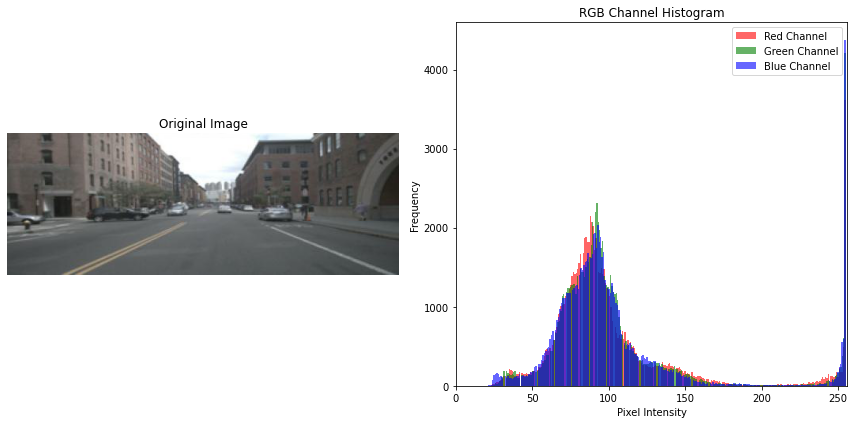

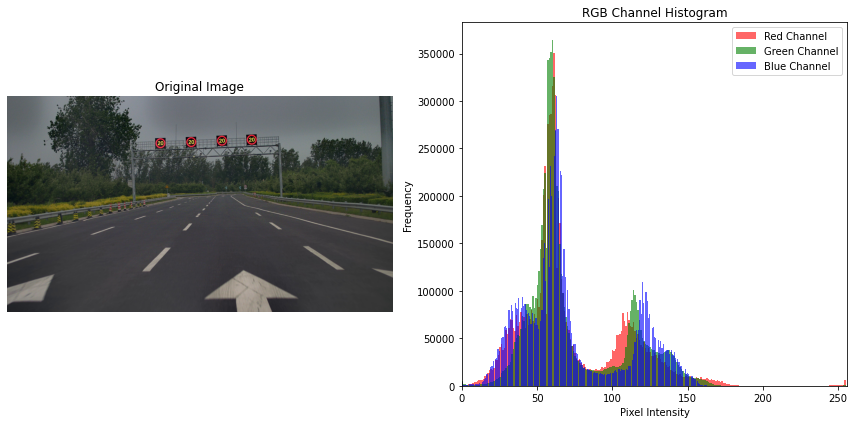

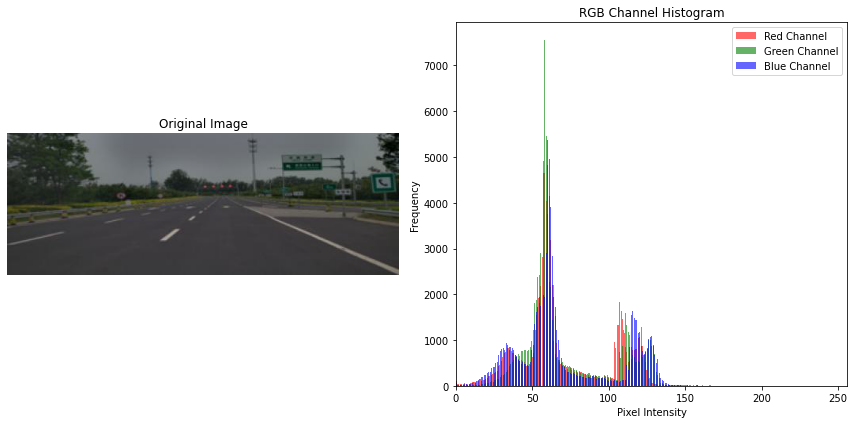

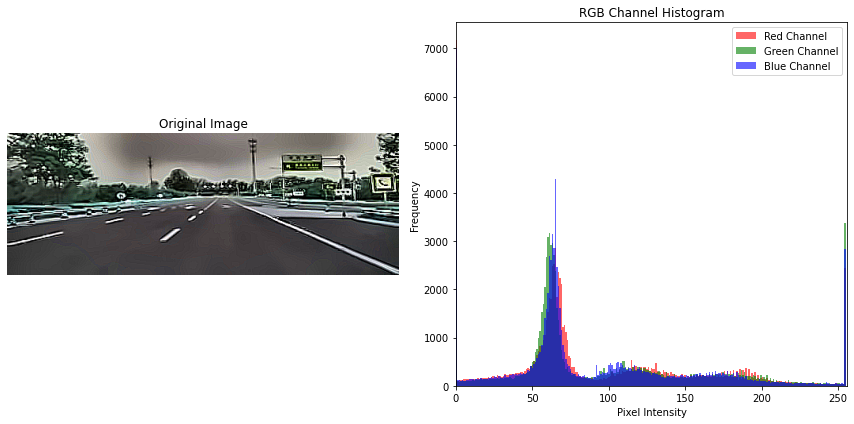

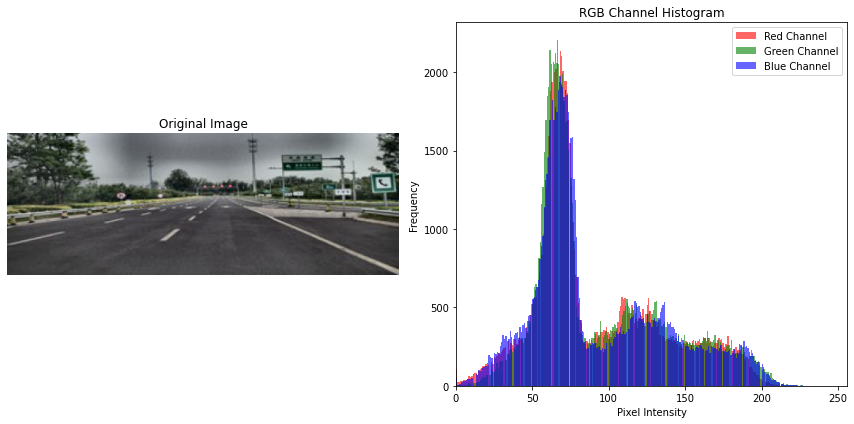

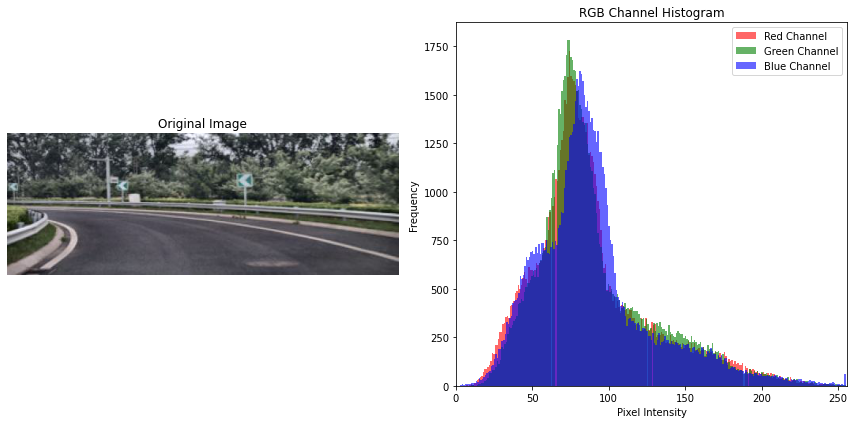

In [1]:
import os
import cv2
from cv2 import xphoto
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def isp_module(image):
    """
    模拟ISP处理，包括白平衡、曝光调整、降噪和锐化。

    参数:
        image (numpy.ndarray): 输入的BGR图像。

    返回:
        numpy.ndarray: 处理后的图像。
    """
    
    # 白平衡
    def simple_white_balance(img):
        """
        简单的白平衡调整。
        """
        # 分离三个颜色通道
        b, g, r = cv2.split(img)
        
        # 获取每个通道的平均值
        b_avg, g_avg, r_avg = map(np.mean, [b, g, r])
        
        # 获取所有通道的平均值
        avg = (b_avg + g_avg + r_avg) / 3
        
        # 计算每个通道的增益系数
        b_gain = avg / b_avg
        g_gain = avg / g_avg
        r_gain = avg / r_avg
        
        # 应用增益系数
        b = cv2.multiply(b, b_gain)
        g = cv2.multiply(g, g_gain)
        r = cv2.multiply(r, r_gain)
        
        # 合并调整后的通道
        return cv2.merge([b, g, r])
    
    def white_balance2(img):
        # Convert the image to LAB color space
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        
        # Split the LAB image into its channels
        l, a, b = cv2.split(lab)
        
        # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to the L-channel
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        cl = clahe.apply(l)
        
        # Merge the CLAHE enhanced L-channel back with A and B channels
        limg = cv2.merge((cl, a, b))
        
        # Convert the LAB image back to BGR color space
        balanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
        
        return balanced_img

    # 曝光调整
    def adjust_exposure(img):
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
        v = cv2.equalizeHist(v)
        final_hsv = cv2.merge((h, s, v))
        img_result = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
        return img_result

    # 降噪
    def denoise(img):
        result = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)
        return result
    
    def color_adaptation(img, saturation_scale=1.3):
        """
        调整图像的饱和度以增强色彩表现。
        
        参数:
            img (numpy.ndarray): 输入的BGR图像。
            saturation_scale (float): 饱和度调整因子，默认值为1.3。
            
        返回:
            numpy.ndarray: 色彩自适应后的图像。
        """
        # 将图像从BGR转换到HSV
        hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv_img)
        
        # 调整饱和度
        s = cv2.multiply(s, saturation_scale)
        s = np.clip(s, 0, 255)  # 确保饱和度值在合法范围内
        
        # 重新组合并转换回BGR
        adjusted_hsv = cv2.merge([h, s, v])
        adjusted_img = cv2.cvtColor(adjusted_hsv, cv2.COLOR_HSV2BGR)
        return adjusted_img

    # 锐化
    def sharpen(img):
        kernel = np.array([[-1, -1, -1],
                           [-1,  9, -1],
                           [-1, -1, -1]])
        result = cv2.filter2D(img, -1, kernel)
        return result

    # 应用白平衡
    # wb_img = simple_white_balance(image)
    wb_img = white_balance2(image)
    
    # 应用曝光调整
    # exp_img = adjust_exposure(wb_img)
    
    # 应用降噪
    dn_img = denoise(wb_img)

    # 应用色彩自适应
    ca_img = color_adaptation(dn_img)
    
    # 应用锐化
    sharp_img = sharpen(ca_img)
    
    return sharp_img

def clahe(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(3, 3))
    img_yuv[:, :, 0] = clahe.apply(img_yuv[:, :, 0])
    img_clahe = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    return img_clahe

def white_balance2(img):
    # Convert the image to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    
    # Split the LAB image into its channels
    l, a, b = cv2.split(lab)
    
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to the L-channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    
    # Merge the CLAHE enhanced L-channel back with A and B channels
    limg = cv2.merge((cl, a, b))
    
    # Convert the LAB image back to BGR color space
    balanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    
    return balanced_img

def histogram_equalization(img):
    # 分离RGB通道
    channels = cv2.split(img)
    
    # 对每个通道进行直方图均衡化
    eq_channels = []
    for ch in channels:
        eq_channels.append(cv2.equalizeHist(ch))
    
    # 合并通道
    eq_img = cv2.merge(eq_channels)
    return eq_img

def gaussian_blur(img):
    # 定义高斯核
    kernel = np.array([[1, 2, 1], 
                       [2, 4, 2], 
                       [1, 2, 1]], np.float32) / 16
    
    kernel2 = np.array([[1, 4, 7, 4, 1],
                       [4, 16, 26, 16, 4], 
                       [7, 26, 41, 26, 7],
                       [4, 16, 26, 16, 4],
                       [1, 4, 7, 4, 1]], np.float32) / 273
    
    # 应用高斯滤波
    gaussian_img = cv2.filter2D(img, -1, kernel2)
    return gaussian_img

def normalize_and_standardize_image(img):
    """
    对输入的OpenCV图像进行归一化和标准化处理。

    参数:
        img (numpy.ndarray): BGR格式的图像数组。

    返回:
        numpy.ndarray: 处理后的图像数组。
    """
    # 确保图像数据类型正确
    if img.dtype != np.float32:
        img = img.astype(np.float32)
    
    # 归一化：将像素值从0-255缩放到0-1
    img /= 255.0
    
    # ImageNet用于预训练模型的均值和标准差（BGR格式）
    mean = np.array([0.406, 0.456, 0.485])  # BGR
    std = np.array([0.225, 0.224, 0.229])   # BGR
    
    # 标准化：减去均值，除以标准差
    img = (img - mean) / std
    
    return img.astype(np.uint8)

def display_image_and_histogram(image_path):
    # 打开图像
    img = Image.open(image_path)
    
    # 将图像转换为 RGB 模式
    img = img.convert('RGB')
    
    # 提取 RGB 通道数据
    r, g, b = img.split()
    r_data = r.getdata()
    g_data = g.getdata()
    b_data = b.getdata()
    
    # 显示原图像
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')
    
    # 计算并显示 RGB 通道的直方图
    plt.subplot(1, 2, 2)
    plt.hist(r_data, bins=256, color='red', alpha=0.6, label='Red Channel')
    plt.hist(g_data, bins=256, color='green', alpha=0.6, label='Green Channel')
    plt.hist(b_data, bins=256, color='blue', alpha=0.6, label='Blue Channel')
    plt.title('RGB Channel Histogram')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.xlim([0, 256])
    
    # 显示图像和直方图
    plt.tight_layout()
    plt.show()

def display_image_and_histogram_without_path(img):
    # 打开图像
    # img = Image.open(image_path)
    
    # 将图像转换为 RGB 模式
    img = img.convert('RGB')
    
    # 提取 RGB 通道数据
    r, g, b = img.split()
    r_data = r.getdata()
    g_data = g.getdata()
    b_data = b.getdata()
    
    # 显示原图像
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')
    
    # 计算并显示 RGB 通道的直方图
    plt.subplot(1, 2, 2)
    plt.hist(r_data, bins=256, color='red', alpha=0.6, label='Red Channel')
    plt.hist(g_data, bins=256, color='green', alpha=0.6, label='Green Channel')
    plt.hist(b_data, bins=256, color='blue', alpha=0.6, label='Blue Channel')
    plt.title('RGB Channel Histogram')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.xlim([0, 256])
    
    # 显示图像和直方图
    plt.tight_layout()
    plt.show()

# 输入图像文件路径
n005_01_front = '/home/sherlock/Pictures/RGB_test_platform/n005/01-45/01_DhIYqPEelY3JMPKTRZjn2efdDXcK4fWR/2_pvimg_before_norm_CAM_FRONT_5409.0.jpg'
n005_01_wb_front = '/home/sherlock/Pictures/RGB_test_platform/n005/01-45/01_wb_DhIYqPEelY3JMPKTRZjn2efdDXcK4fWR/2_pvimg_before_norm_CAM_FRONT_5409.0.jpg'
n005_45_front = '/home/sherlock/Pictures/RGB_test_platform/n005/01-45/45_QiXipuRsv5E33cyqdWsuy3IUYoVWr70G/2_pvimg_before_norm_CAM_FRONT_5431.0.jpg'
n005_45_wb_front = '/home/sherlock/Pictures/RGB_test_platform/n005/01-45/45_wb_QiXipuRsv5E33cyqdWsuy3IUYoVWr70G/2_pvimg_before_norm_CAM_FRONT_5431.0.jpg'
img2 = '/home/sherlock/Pictures/RGB_test_platform/img2.jpg'
img3 = '/home/sherlock/Pictures/RGB_test_platform/img.jpg'
nu = '/home/sherlock/Documents/Projects/HDMapNet-test/plt_images/nuscenes/mini_dataset_E43/b6b0d9f2f2e14a3aaa2c8aedeb1edb69/2_pvimg_before_norm_CAM_FRONT_1533151608512404.jpg'
org = '/home/sherlock/Documents/Projects/HDMapNet-test/dataset/input_frames_videos/camera_front_tele_sat_30fov_frames/n005_e_straight_24s_camera_front_tele_30fov_5419.966666666666_3779.jpg'
# 读取图像
img = cv2.imread(n005_01_front)# image_path_n005_01_front

# 应用直方图均衡化
eq_img = isp_module(img)
# eq_img = white_balance2(eq_img)
# eq_img = colour_norm(eq_img)

# 应用高斯滤波
# blurred_img = gaussian_blur(img)
# blurred_img = cv2.medianBlur(img, 5)
# blurred_img = cv2.blur(blurred_img, (7,7))

# 显示结果
# cv2.imshow('Original', img)
# cv2.imshow('Equalized', eq_img)
# cv2.imshow('Blurred', blurred_img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
img = Image.fromarray(eq_img)
# img.save('img.jpg')


# 调用函数显示图像及其 RGB 直方图

# img_np = cv2.imread(test)
# img_np = gaussian_blur(img_np)
# img = Image.fromarray(img_np)
display_image_and_histogram(nu)
display_image_and_histogram(org)
display_image_and_histogram(n005_01_front)
display_image_and_histogram_without_path(img)
display_image_and_histogram(n005_01_wb_front)
display_image_and_histogram(n005_45_wb_front)
# display_image_and_histogram(test_120fov_front_wide)
# display_image_and_histogram(image_path_n005_21_back)
# display_image_and_histogram(image_path_n005_41_back)
# display_image_and_histogram(img3)

In [3]:
import os
from PIL import Image

def process_images(input_folder, output_folder):
    # 获取输入文件夹的绝对路径
    input_folder = os.path.abspath(input_folder)
    
    # 创建输出文件夹
    output_folder = os.path.join(os.path.dirname(output_folder), 'processed_images')
    os.makedirs(output_folder, exist_ok=True)
    
    # 获取输入文件夹中的所有图像文件
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)
            
            # 打开图像
            with Image.open(input_path) as img:
                width, height = img.size
                
                # 裁剪图像的下半部分
                lower_half = img.crop((0, height // 2, width, height))
                
                # 将下半部分拉伸到原图像的高度
                stretched_lower_half = lower_half.resize((width, height), Image.Resampling.LANCZOS)
                
                # 保存处理后的图像
                stretched_lower_half.save(output_path)
    
    print(f"Processed images are saved in {output_folder}")

# 输入文件夹路径
input_folder = '/home/sherlock/Documents/Projects/dataset/mb2-2_front/CAM_FRONT_LEFT'
output_folder = '/home/sherlock/Documents/Projects/dataset/mb2-2_front/'

# 调用函数进行批量处理
process_images(input_folder, output_folder)


Processed images are saved in /home/sherlock/Documents/Projects/dataset/mb2-2_front/processed_images


### Change jpg files name

In [ ]:
import os

PATH = '/home/sherlock//Documents/Projects/HDMapNet-test/dataset/input_frames_videos/camera_rear_tele_30fov_frames'

def rename_files(directory):
    # 列出目录中的所有文件
    files = os.listdir(directory)
    
    for filename in files:
        # 检查文件是否以"n005"开头并且是.jpg文件
        if filename.startswith("n005") and filename.endswith(".jpg"):
            # 构造新的文件名
            new_filename = "n006" + filename[4:]
            # 获取旧文件路径和新文件路径
            old_file = os.path.join(directory, filename)
            new_file = os.path.join(directory, new_filename)
            # 重命名文件
            os.rename(old_file, new_file)
            print(f'Renamed: {old_file} to {new_file}')

# 使用方法，将 'your_directory_path' 替换为你的文件夹路径
rename_files(PATH)


### Distortion of jpg camera files

In [ ]:
import cv2
from PIL import Image
import numpy as np
import os
import glob

cam_intrinsics = np.array([[1872.2064208984375, 0.0, 1912.15283203125],
                           [0.0, 1872.2064208984375, 1501.535888671875],
                           [0.0, 0.0, 1.0]], dtype=np.float32)

distortion = np.array([[0.0018148268052000864],
                       [-0.018532995988586563],
                       [0.0],
                       [0.0]], dtype=np.float32)

# 全局变量，定义输入和输出文件夹的路径
input_folder_path = 'dataset/samples/CAM_FRONT_RIGHT'
output_folder_name = "_distorted"

def distort_images(input_folder, output_folder, K=cam_intrinsics, D=distortion, resolution=(3840, 2160)):
    """批量去除图像畸变

    :param input_folder: 输入图像文件夹的路径
    :param output_folder: 输出图像文件夹的路径
    :param K: 相机内参，np.array(3x3)
    :param D: 相机镜头畸变系数，np.array(4x1)
    :param resolution: 图像分辨率
    """
    # 确保输出文件夹存在
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # 获取所有图像文件的路径
    images_path = glob.glob(os.path.join(input_folder, '*'))
    
    for img_path in images_path:
        img_name = os.path.basename(img_path)
        output_path = os.path.join(output_folder, img_name)
        
        img = Image.open(img_path)
        img = img.resize(resolution)
        img_bgr = cv2.cvtColor(np.asarray(img), cv2.COLOR_RGB2BGR)

        img_distort = cv2.fisheye.undistortImage(img_bgr, K, D, None, K, resolution)
        img_distort = cv2.cvtColor(img_distort, cv2.COLOR_BGR2RGB)
        img_distort = Image.fromarray(img_distort)
        img_distort.save(output_path)
        print("Image saved!")

def main():
    output_folder_path = os.path.join(os.path.dirname(input_folder_path), os.path.basename(input_folder_path) + output_folder_name)
    distort_images(input_folder_path, output_folder_path)
    print("All images distorted!")

if __name__ == "__main__":
    main()


### Check json file adresse

In [ ]:
import json

PATH = 'dataset/MB_dataset2/mb_test/sample_data.json'

with open(PATH, 'r') as f:
    data = json.load(f)
    for item in data:
        print(item['filename'])


### 修改 sample_data.json 中的关键词

In [2]:
import json

def modify_json_file(input_file, output_file):
    # 读取 JSON 文件
    with open(input_file, 'r') as f:
        data = json.load(f)
    
    # 如果 JSON 文件内容是一个列表
    if isinstance(data, list):
        for record in data:
            # 修改 is_key_frame 字段
            if 'is_key_frame' in record:
                record['is_key_frame'] = True
            if 'fileformat' in record:
                record['fileformat'] = "jpg"
    
    # 如果 JSON 文件内容是一个字典
    elif isinstance(data, dict):
        # 修改 is_key_frame 字段
        if 'is_key_frame' in data:
            data['is_key_frame'] = True
        if 'fileformat' in data:
                record['fileformat'] = "jpg"
    
    # 将修改后的内容写回到新的 JSON 文件
    with open(output_file, 'w') as f:
        json.dump(data, f, indent=4)

# 输入文件名和输出文件名
input_file = 'dataset/MB_dataset2/mb_test/sample_data.json'
output_file = 'modified_data.json'

# 调用函数进行修改
modify_json_file(input_file, output_file)
